# Week 7: Merger Trees and Particle Snapshots

### Imports

In [3]:
#Note: there are some new imports here!
import os 
import numpy as np
import pickle
from helpers.SimulationAnalysis import SimulationAnalysis, readHlist
import matplotlib.pylab as plt
import pynbody
import meshoid
from meshoid import Meshoid
import seaborn as sns
import matplotlib.colors as colors

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}
plt.rc("text", usetex=True)
custom_blues_complement = ["#FFBB99", "#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300", "#662200","#000000"]

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}
custom_blues = ["#99DDFF","#66CCFF", "#33BBFF", "#00AAFF", "#0088CC", "#006699", "#004466", "#000000"]
custom_blues_complement = ["#FFBB99", "#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300", "#662200","#000000"]
custom_cet_fdm = ["#EE99FF","#E566FF","#DD33FF","#D400FF","#AA00CC","#7F0099"]
#["#fc5eff","#e330ff","#b11eff"]

sim_colors = {}
sim_colors['cdm'] = 'k'
sim_colors['vd100'] = 'm'
sim_colors['wdm_3.5'] = custom_blues_complement[1]
sim_colors['wdm_6.5'] = custom_blues_complement[4]
sim_colors['Tkd_0.72kev'] = 'teal'
sim_colors['Tkd_0.72kev_vd100'] = 'teal'
sim_colors['Tkd_1.46kev'] = 'goldenrod'
sim_colors['Tkd_1.46kev_vd100'] = 'goldenrod'
sim_colors['Tkd_2.32kev'] = 'brown'
sim_colors['Tkd_2.32kev_vd100'] = 'brown'

sim_colors['wdm_3'] = custom_blues_complement[0]
sim_colors['wdm_4'] = custom_blues_complement[1]
sim_colors['wdm_5'] = custom_blues_complement[2]
sim_colors['wdm_6'] = custom_blues_complement[3]
sim_colors['wdm_6.5'] = custom_blues_complement[4]
sim_colors['wdm_10'] = custom_blues_complement[5]
sim_colors['idm_1e-4GeV'] = custom_blues[0]
sim_colors['idm_1e-2GeV'] = custom_blues[2]
sim_colors['idm_1GeV'] = custom_blues[4]
sim_colors['fdm_25.9e-22eV'] = custom_cet_fdm[0]
sim_colors['fdm_69.4e-22eV'] = custom_cet_fdm[1]
sim_colors['fdm_113e-22eV'] = custom_cet_fdm[2]
sim_colors['fdm_151e-22eV'] = custom_cet_fdm[3]
sim_colors['fdm_185e-22eV'] = custom_cet_fdm[4]
sim_colors['fdm_490e-22eV'] = custom_cet_fdm[5]

## Merger Trees

"Merger trees" are structures that encode the evolution of all halos and subhalos in a simulation. Specifically, merger trees contain information about the progenitors and descendants of all (sub)halos in a simulation, and how different (sub)halos relate to each other. For example, if two halos (A and B) merge to form a larger halo (C), halo C's progenitors are {A and B}, and halo A and B will each have a progenitor {C}.

In the Week 1 notebook, we used the "main branch" of the host halo in one simulation to plot its mass accretion history. A particular halo's main branch is defined as a sequence of its progenitors, throughout the entire simulation, where at each branching event the more massive progenitor is selected. In the example above, if halo B is more massive than halo A, then halo C's main branch would contain halo B (but not halo A).

Merger trees can be represented as graphical structures; e.g., see [here](https://www.illustris-project.org/data/docs/specifications/#sec3). There are several helpful resources for understanding merger trees, including [this page](http://astro.dur.ac.uk/~jch/password_pages/merger_trees.html), the [consistent-trees paper](https://arxiv.org/abs/1110.4370) (this is the merger tree format we use!), and particularly this [merger tree comparison paper](https://arxiv.org/abs/1307.3577).

The code below provides examples of how to (1) load main branches, and (2) identify progenitor, descendant, and "root descendant" (sub)halos (the "root descendant" is the most massive (sub)halo that a given (sub)halo descends to at $z=0$).

### 1. Loading main branches

Merger trees for each simulation are stored in the corresponding `rockstar/trees` folders, which are created when `consistent-trees` is run. The `tree_*.dat` file(s) contain the merger tree itself.

In [4]:
BASE_PATH = '/central/groups/carnegie_poc/enadler/ncdm_resims/'

halo_num = 'Halo004/'
model = 'cdm/'

print(os.listdir(BASE_PATH+halo_num+model+'output/rockstar/trees/'))

['tree_0_0_0.dat', 'forests.list', 'locations.dat']


Next, we define a simulation object, `sim`, that represents the merger tree. We then use this object to load the main branch of the most massive halo found at $z=0$ (which turns out to be the host halo in this simulation, although this won't necessarily be the case in general).

In [14]:
#Define simulation object
sim = SimulationAnalysis(trees_dir=BASE_PATH+halo_num+model+'output/rockstar/trees')

#Load hlist at z = 0
halos = readHlist(BASE_PATH+halo_num+model+'output/rockstar/hlists/hlist_1.00000.list')

#Load main branch of most massive halo
most_massive_halo = halos[np.argmax(halos['Mvir'])]
host_main_branch = sim.load_main_branch(most_massive_halo['id'])

Finally, we plot the mass accretion history this halo, just like in the Week 1 notebook.

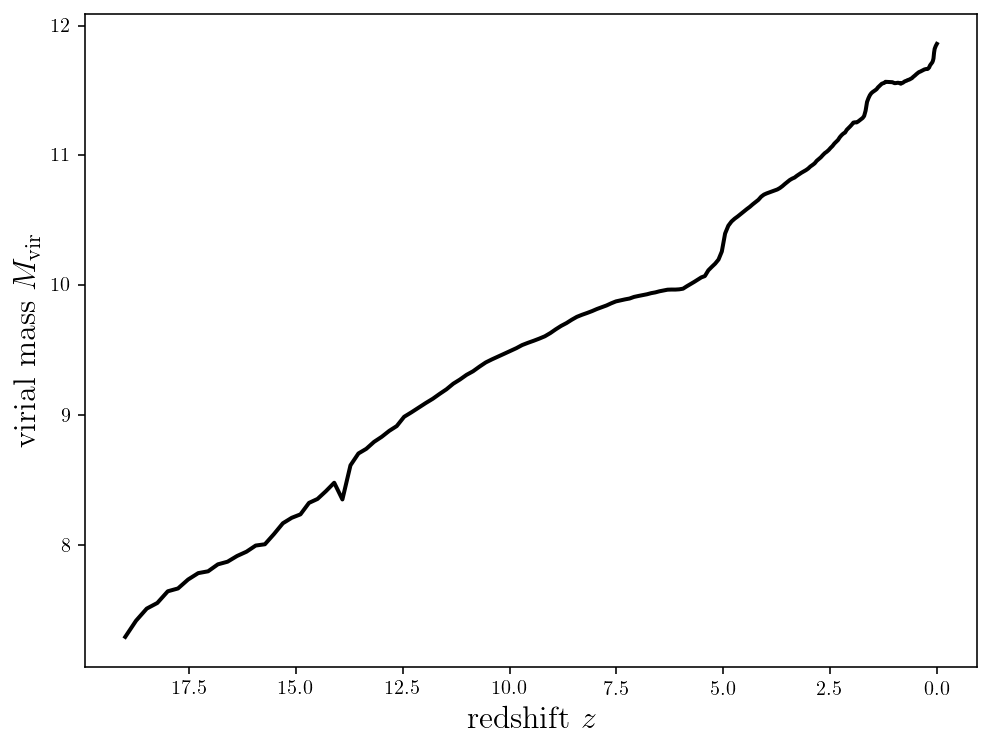

In [15]:
#Plot mass accretion history
plt.figure(figsize=(8,6))

redshift = 1./host_main_branch['scale'] - 1.
mass_accretion_history = np.log10(host_main_branch['mvir'])

plt.plot(redshift,mass_accretion_history,lw=2,c=sim_colors['cdm'])

plt.xlabel(r'$\mathrm{redshift\ } z$',fontsize=16)
plt.ylabel(r'$\mathrm{virial\ mass\ } M_{\mathrm{vir}}$',fontsize=16)

plt.gca().invert_xaxis()
plt.show()

We can load the main branch of any halo in the simulation. As an example, let's load the main branch of the most massive subhalo of the host, identified at $z=0$, and compare its main branch to that of the host:

In [19]:
#Find subhalos of the host at z = 0
subhalos = halos[halos['upid']==host['id']]

#Load main branch of most massive subhalo
most_massive_sub = subhalos[np.argmax(subhalos['Mvir'])]
sub_main_branch = sim.load_main_branch(most_massive_sub['id'])

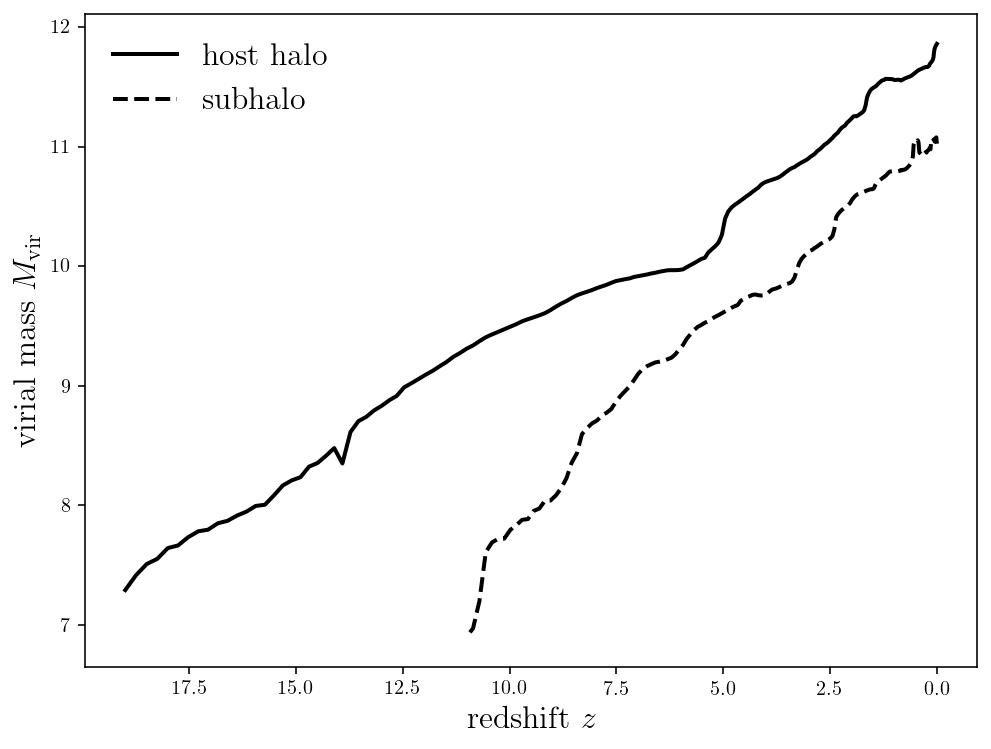

In [21]:
#Plot mass accretion history
plt.figure(figsize=(8,6))

redshift = 1./host_main_branch['scale'] - 1.
mass_accretion_history = np.log10(host_main_branch['mvir'])

plt.plot(redshift,mass_accretion_history,lw=2,c=sim_colors['cdm'],label=r'$\mathrm{host\ halo}$')

###

redshift = 1./sub_main_branch['scale'] - 1.
mass_accretion_history = np.log10(sub_main_branch['mvir'])

plt.plot(redshift,mass_accretion_history,lw=2,c=sim_colors['cdm'],ls='--',label=r'$\mathrm{subhalo}$')

###

plt.xlabel(r'$\mathrm{redshift\ } z$',fontsize=16)
plt.ylabel(r'$\mathrm{virial\ mass\ } M_{\mathrm{vir}}$',fontsize=16)
plt.legend(loc=2,fontsize=16,frameon=False)

plt.gca().invert_xaxis()
plt.show()

### 2. Identifying progenitor, descendant, and root descendant (sub)halos

The `hlist` files contain all information about (sub)halo progenitors and descendants. When we say "progenitor" (or "descendant") without further specification, we mean the progenitor (or descendant) at the snapshot immediately preceding (or following) the snapshot in question.

For example, let's find the progenitor of the host at the snapshot that immediately precedes $z=0$. We can then show that this halo descends to the host at $z=0$, as expected:

In [28]:
#Load halos at the snapshot before z = 0
halos_preceding = readHlist(BASE_PATH+halo_num+model+'output/rockstar/hlists/hlist_0.98733.list')

#Find index of host halo at the snapshot before z = 0 (index 1 in the main branch)
host_prog_id = host_main_branch[1]['id']
prog = halos_preceding[halos_preceding['id']==host_prog_id]

#Check that this halo correctly descends to the host at z = 0 (index 0 in the main branch)
print(prog['desc_id']==host_main_branch[0]['id'])

[ True]


Finally, (sub)halo "tree root" descendants can be useful. For example, we can use them to check what a halo identified at $z>0$ descends to:

In [34]:
#Suppose we had identified a massive halo at an early time, say z = 1:
halos_z1 = readHlist(BASE_PATH+halo_num+model+'output/rockstar/hlists/hlist_0.50239.list')
most_massive_halo_z1 = halos_z1[np.argmax(halos_z1['Mvir'])]

#It turns out that the most massive halo at z = 1 is the main branch progenitor of the host!
print(most_massive_halo_z1['Tree_root_ID']==host_main_branch[0]['id'])

True


## Particle Snapshots

Simulations track the evolution of particles; halo lists and merger trees are derived from the particle data, after the simulation is run. At each snapshot, the positions and velocities of all particles fully define the simulation data.

The code below demonstrates how to load and visualize particle snapshots using the `pynbody` package (documentation [here](https://pynbody.github.io/pynbody/)).

In [50]:
#Load particles at z = 0
f = pynbody.load('/central/groups/carnegie_poc/enadler/ncdm_resims/Halo004/cdm/output/snapshot_235')

#Print loadable data
print(f.loadable_keys())
print('\n')

#Load positions
pos = f['pos']
print(pos)
print('\n')

print(pos.shape)

['mass', 'vel', 'iord', 'pos']


[[61.239326 61.9916   60.52831 ]
 [61.164772 62.00882  60.476414]
 [61.17074  61.966503 60.494312]
 ...
 [61.90266  62.339005 75.84499 ]
 [62.434425 62.429874 76.20518 ]
 [62.348423 61.361282 76.209946]]


(40838988, 3)


The particle data is huge, containing over 40 million particles. To make handling it more convenient, this function allows us to subselect particles near the host halo: 

In [45]:
def subselect_particles(f,host,distance_cut=1.5,Mpc_to_kpc=1000.):
    """
    Return particles within a radius of {distance_cut} kpc and a z-distance of +/-{projection_thickness} Mpc/h 
    from the host halo center
    
    Args:
        f (dictionary of pynbody objects): particle data at snapshot(s)
        host_halo (Rockstar object): host halo information
        distance_cut (float): radial distance from center of host to subselect, in kpc
        projection_thickness (float): absolute z-distance to subselect, in Mpc/h
        
    Returns:
        f_short (pynbody object): subselected particle data at snapshot(s)
    """
    
    xdist = f['pos'][:,0]-host['x']
    ydist = f['pos'][:,1]-host['y']
    zdist = f['pos'][:,2]-host['z']
    dist = Mpc_to_kpc*np.sqrt(xdist**2+ydist**2+zdist**2)/host['Rvir']
    f_short = f[(dist<distance_cut)]
        
    return f_short

We now use this function to select particles near the host and center our coordinates on the host:

In [52]:
#Subselect particles
f_short = subselect_particles(f,host)

#Define variables
rho = f_short["rho"][:]
density_cut = (rho > .1)
pdata = {}
pdata['Masses'] = f_short['mass'][density_cut]
pdata['Coordinates'] = f_short['pos'][density_cut]
pdata['SmoothingLength'] = np.ones(len(f_short))[density_cut]*20/1000.
pdata['Velocities'] = f_short['vel'][density_cut]

#Center on the host halo
pos = pdata["Coordinates"]*1000.
center = np.median(pos,axis=0)
center[0], center[1], center[2] = host['x']*1000, host['y']*1000, host['z']*1000
pos -= center
radius_cut = np.sum(pos*pos,axis=1) < 0.75*host['Rvir']*0.75*host['Rvir']
pos_new = pos
pos_new[:,1] = pos[:,2]
pos_new[:,2] = pos[:,1]
pos, mass, hsml, v = pos_new[radius_cut], pdata["Masses"][radius_cut], pdata["SmoothingLength"][radius_cut], pdata["Velocities"][radius_cut]

Finally, we can visualize the result:

In [54]:
host['Rvir']

184.336

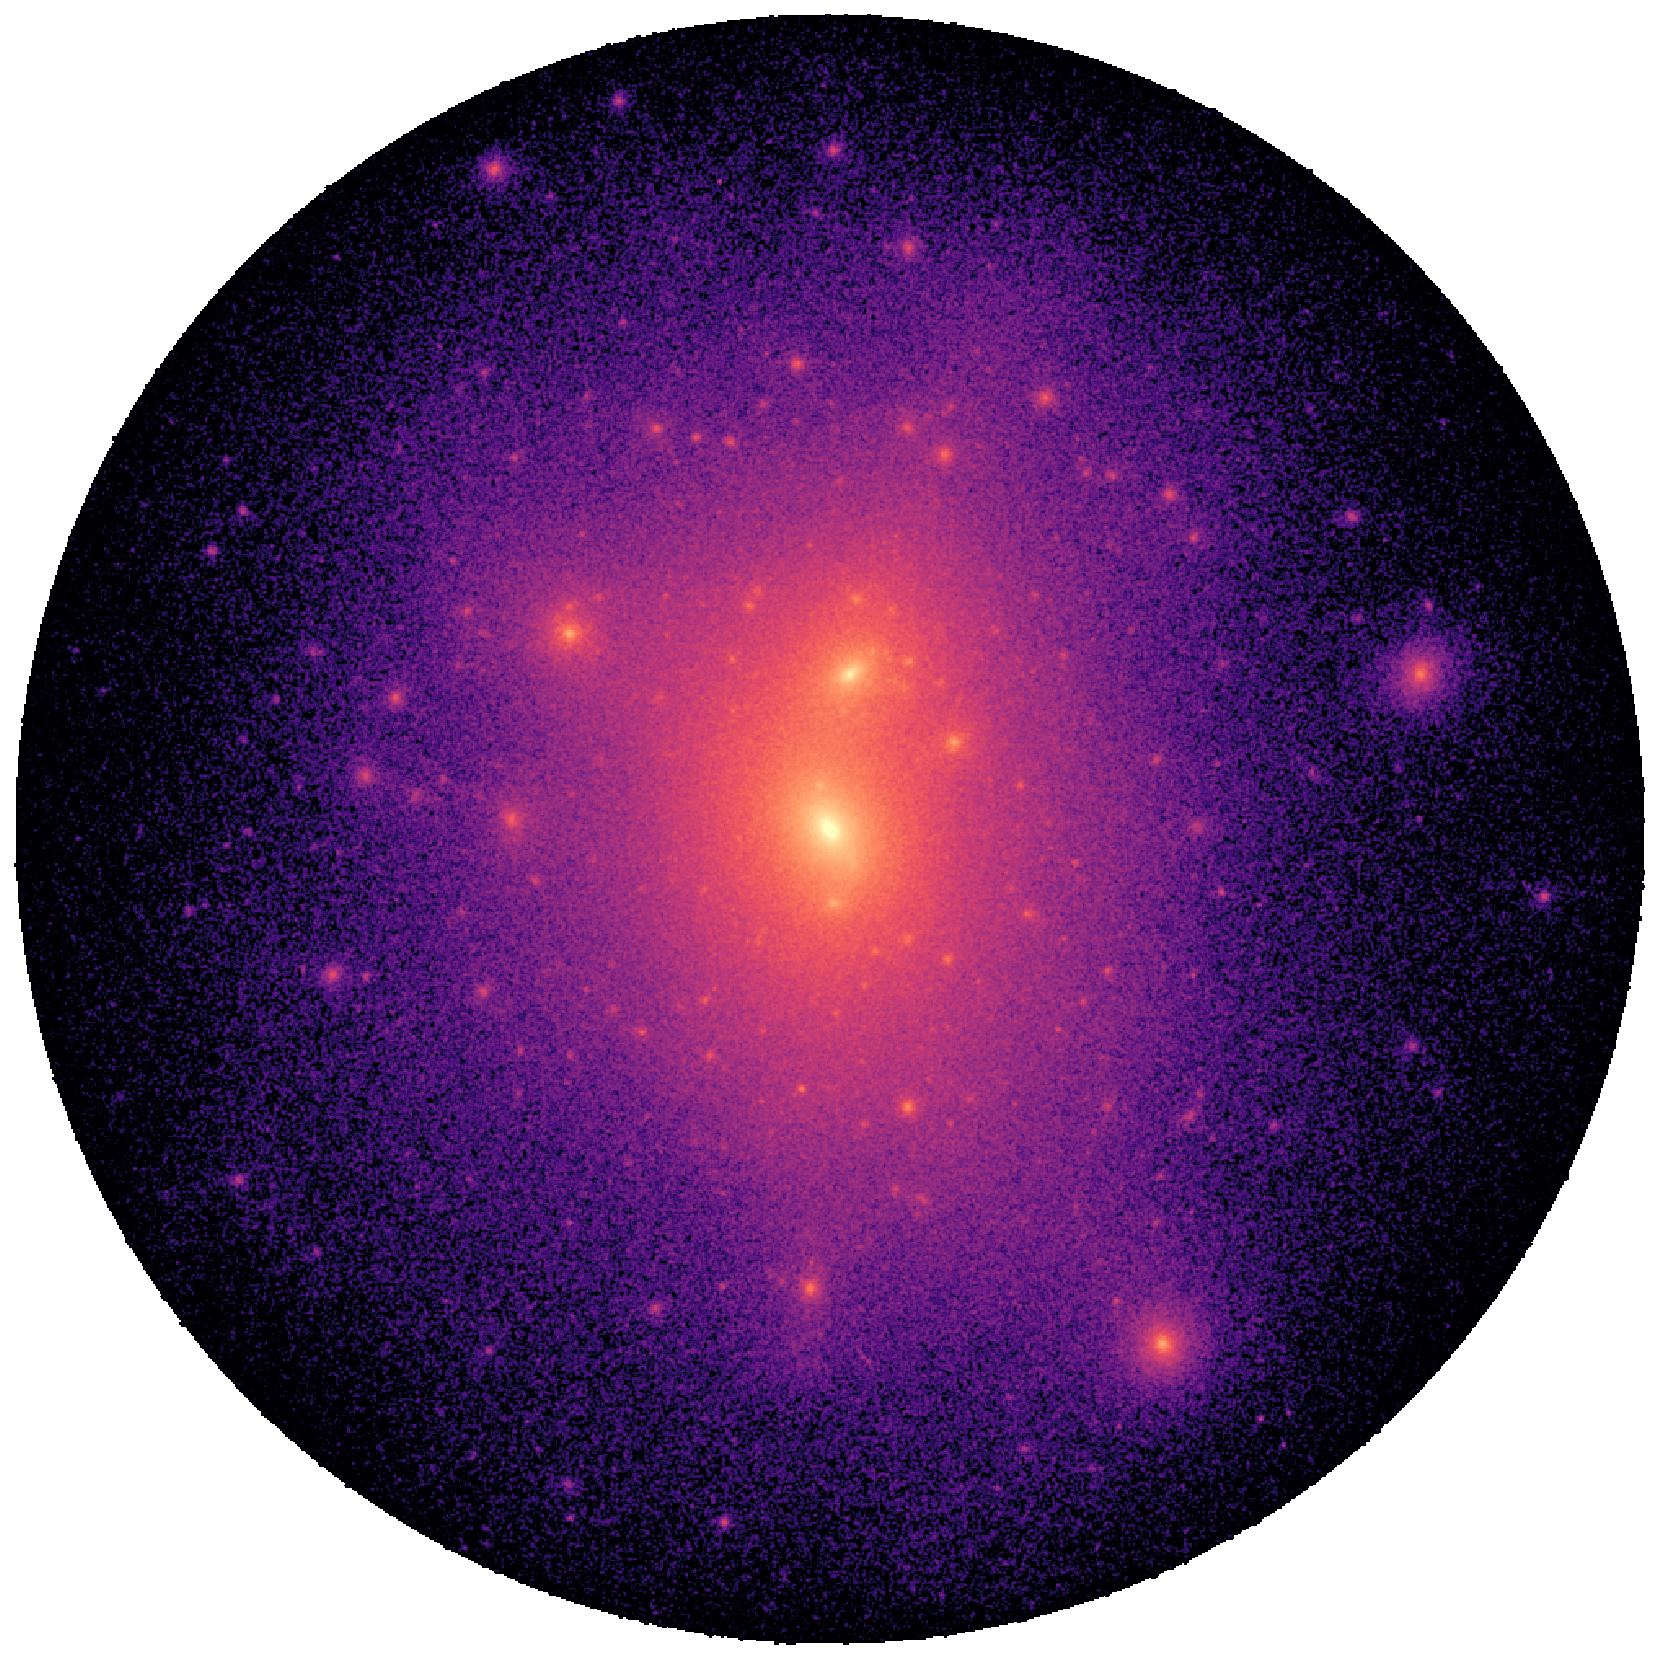

In [57]:
M = Meshoid(pos, mass, hsml)
rmax = 1.5*host['Rvir']

res = 1000
X = Y = np.linspace(-rmax, rmax, res)
X, Y = np.meshgrid(X, Y)
fig, ax = plt.subplots(figsize=(15,15))
sigma_gas_msun_pc2 = M.SurfaceDensity(M.m,center=np.array([0.,0.,0.]),size=1.5*host['Rvir'],res=res)*1e4
sigma_gas_msun_pc2[np.sqrt(X**2 + Y**2) < 1.5*host['Rvir']] = sigma_gas_msun_pc2[np.sqrt(X**2 + Y**2) < 1.5*host['Rvir']].clip(min=0.8)
p = ax.pcolormesh(X, Y, sigma_gas_msun_pc2.T, norm=colors.LogNorm(vmin=0.8,vmax=1e3), cmap='magma')

ax.set_aspect('equal')
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
ax.axis('off')

plt.show()